---
title: "Model Evaluation Rules: Cross Validation"
author: Daniel Redel
date: today
format:
  html:
    toc: true
    code-fold: false
    html-math-method: katex
jupyter: python3
---

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Once a predictive model (_classifier_ or _regressor_) is constructed, it is particularly important to **evaluate its performance**. Model evaluation stage include the use of methods and metrics to estimate the predictive performance of a model. To understand the model evaluation process, it would be helpful to distinguish between **evaluation rules** and **evaluation metrics**.

-  A **evaluation metric** is used to quantify the performance of a constructed model.
-  A **model evaluation rule**, on the other hand, refers to the procedure that is used to estimate a metric. In other words, a metric could be estimated using various rules.

For simplicity of discussion, in what follows, estimation rules are described in connection with classification error rate. However, all procedures, except when stated otherwise, are applicable to estimating classifier and regressor performance metrics.

For more, check here: https://scikit-learn.org/stable/model_selection.html#model-selection

# Hold-Out Estimator

Suppose that we would like to estimate the test error associated with fitting a particular statistical learning method on a set of observations. The **Hold-Out Approach** is a very simple strategy validation set approach for this task:

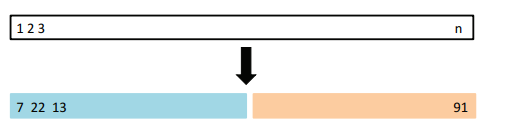

> It involves randomly **dividing** the available set of observations **into two parts**, a **training set** and a **validation set** or **hold-out set**.

*The **model is fit on the training set**, and the fitted model is used to predict the responses for the observations in the validation set.*

The validation set approach is conceptually simple and is easy to implement. But it has two potential drawbacks:

1. Results can be highly variable, depending which observations are included in the training set.
2. Only a subset of the observations are used to fit the model.


## Application with `train_test_split`

Let's go back to our kNN classifier example:

In [2]:
#| label: tbl-raw-dataset
#| tbl-cap: Iris Dataset
#| code-fold: true

from sklearn import datasets
iris = datasets.load_iris()

df = pd.DataFrame(iris.data, columns=iris.feature_names)
# Add target
df['target'] = iris.target

# Dictionary
target_names_dict = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

# Add the target names column to the DataFrame
df['target_names'] = df['target'].map(target_names_dict)
df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In `scikit-learn` a random split into training and test sets can be quickly computed with the `train_test_split` helper function. For example, we can now quickly sample a training set while holding out 40% of the data for testing (evaluating) our classifier:

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as kNN

# Target vs Inputs
X = df.drop(columns=["target", "target_names"]) # Covariates-Only
y = df["target"] # Target-Outcome

# Train vs Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=0)

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 

# Instantiate Class into Object. Set Parameters
knn = kNN(n_neighbors=3)

# Train Model
knn.fit(X_train, y_train)

# Predict
y_test_pred = knn.predict(X_test)

To calculate the test error on the held-out data, we just use the `score` function. 

Note that **each estimator have a default `score` method** providing a evaluation criterion for the problem they are designed to solve.

In [9]:
from sklearn.metrics import accuracy_score, mean_squared_error
print('Accuracy Train', knn.score(X_train, y_train).round(2) ) 
print('Accuracy Test', knn.score(X_test, y_test).round(2) ) 

Accuracy Train 0.94
Accuracy Test 0.97


# $k$-Fold Cross Validation

The $k$-fold CV approach involves randomly dividing the set of observations into $k$ groups, or folds, of approximately equal size. The first fold is treated as a validation set, and the method is fit on the remaining $k − 1$ folds. 

- The mean squared error, $\text{MSE}_1$, is then computed on the observations in the held-out fold.
- This procedure is repeated $k$ times; each time, ***a different group of observations is treated as a validation set***.

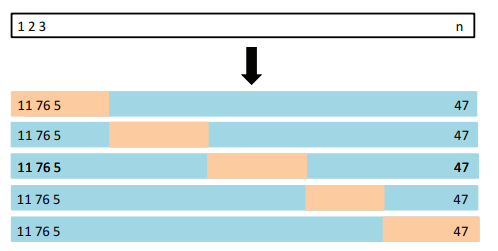

This process results in $k$ estimates of the test error, $\text{MSE}_1,...,\text{MSE}_k$ . The k-fold CV estimate is computed by **averaging these values**:

$$
\text{CV}_k=\frac{1}{k}\sum^k_{i=1}\text{MSE}_k
$$

- It is not hard to see that LOOCV is a special case of $k$-fold CV in which $k$ is set to equal $n$.

It is important to keep in mind that **cross-validation does not return a model**. When calling `cross_val_score`, multiple models are built internally, but the purpose of cross-validation is only to evaluate how well a given algorithm will generalize when trained on a specific dataset.

## Application: `cross_validate` and `cross_val_score`

The simplest way to use cross-validation is to call the `cross_val_score` helper function on the estimator and the dataset. Lets create $k=10$ folds:

In [38]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.model_selection import cross_val_score

# Instantiate Class into Object. Set Parameters
knn = kNN(n_neighbors=3)

# Train Model with K-Fold
scores = cross_val_score(knn, X, y, cv=10)
print("Cross-validation scores: {}".format(scores))

# Mean Score
print( 'Mean Score (Accuracy):', scores.mean().round(2) )

Cross-validation scores: [1.         0.93333333 1.         0.93333333 0.86666667 1.
 0.93333333 1.         1.         1.        ]
Mean Score (Accuracy): 0.97


Splitting the dataset into $k$ folds by starting with the first one-$k$-th part of the data might not always be a good idea. 

By default, `scikit-learn` does not use it for classification, but rather uses **stratified k-fold cross-validation**. In stratified cross-validation, we split the data such that **the proportions between classes are the same in each fold**.

`model_selection.cross_val_score` take a `scoring` parameter that controls what metric they apply to the estimators evaluated. By default, the score computed at each CV iteration is the score method of the estimator. It is possible to change this by using the scoring parameter:

In [35]:
# Train Model with K-Fold
scores = cross_val_score(knn, X, y, cv=10, scoring='f1_macro')

# Mean Score
print( 'Mean Score:', scores.mean().round(2) )

Mean Score: 0.97


Alternatively, there is the `cross_validate` function, which differs a bit from `cross_val_score` in two ways:

- It allows specifying **multiple metrics** for evaluation.
- It returns a dict containing `fit-times`, `score-times` in addition to the `test score`.

In [50]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.model_selection import cross_validate

# Instantiate Class into Object. Set Parameters
knn = kNN(n_neighbors=3)

# Cross validation and performance evaluation
knn_score = cross_validate(knn, X, y, cv=10) 

# Mean Score
print('Mean Score:', knn_score["test_score"].mean().round(2) )

# Scores
knn_score = pd.DataFrame(knn_score)
knn_score.head(3)

Mean Score: 0.97


,fit_time,score_time,test_score
0,0.005152,0.005557,1.000000
1,0.003806,0.004162,0.933333
2,0.003748,0.003971,1.000000


In [46]:
# Call Multiple Metrics
scoring = ['precision_macro', 'recall_macro']
knn_score = cross_validate(knn, X, y, cv=10, scoring=scoring) 
pd.DataFrame(knn_score).head(4)

,fit_time,score_time,test_precision_macro,test_recall_macro
0,0.004226,0.011323,1.000000,1.000000
1,0.002567,0.007165,0.944444,0.933333
2,0.001993,0.006492,1.000000,1.000000
3,0.002992,0.006701,0.944444,0.933333


# Leave-One-Out Cross Validation (LOOCV)

***In LOOCV, a single observation $(x_1, y_1)$ is used for the validation set, and the remaining observations $[(x_2, y_2),...,(x_n, y_n)]$ make up the training set.***

- The statistical learning method is **fit on the $n − 1$ training observations**, and a ***prediction $\hat{y}_1$ is made for the excluded observation***, using its value $x_1$.
- Since $(x_1, y_1)$ was not used in the fitting process, $\text{MSE}_1 = (y_1 − \hat{y}_1)^{2}$ provides an approximately **unbiased estimate for the test error**.
- But even though $\text{MSE}_1$ is unbiased for the test error, it is a poor estimate because it is ***highly variable, since it is based upon a single observation $(x_1, y_1)$***.

**Solution**: We can **repeat the procedure** by selecting $(x_2, y_2)$ for the validation data, training the statistical learning procedure on the $n − 1$ observations $[(x_1, y_1),(x_3, y_3),...,(x_n, y_n)]$, and computing $\text{MSE}_2=(y_2-\hat{y}_2)^2$. 

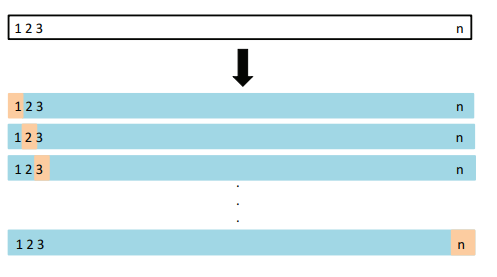

- *Repeating this approach $n$ times produces $n$ squared errors*, $\text{MSE}_1,..., \text{MSE}_n$.

The **LOOCV** estimate for the test MSE is the **average of these $n$ test error estimates**:

$$
\text{CV}_n=\frac{1}{n}\sum^n_{i=1}\text{MSE}_i
$$

## Application with `LeaveOneOut`

In [51]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

scores = cross_val_score(knn , X, y, cv=loo)

print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of cv iterations:  150
Mean accuracy: 0.96
